In [3]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
def binary(img, threshold):
    gray = rgb2gray(img)*255
    bin_img = 255*(gray > threshold)
    return bin_img

In [4]:
def erode_dilate(bin_img, se=np.ones((3,3)).astype(np.bool),flag=0):
    rows, cols = bin_img.shape
    eroded_shape = (
        rows + (se.shape[0]//2 )*2,
        cols + (se.shape[1]//2 )*2
    )
    if flag == 1:
        input_img = np.ones(eroded_shape).astype(np.bool)
    else :
        input_img = np.zeros(eroded_shape).astype(np.bool)
    input_img[se.shape[0]//2:rows+se.shape[0]//2, se.shape[1]//2:cols+se.shape[1]//2] = bin_img.astype(np.bool)

    se = se.astype(np.bool)
    res_img = np.zeros(eroded_shape).astype(np.bool)

    return (res_img, input_img)

In [6]:
def erode(bin_img, se=np.ones((3,3)).astype(np.bool)):
    rows, cols = bin_img.shape
    se_rows, se_cols = se.shape
    eroded_img, input_img = erode_dilate(bin_img, se,1)

    for row in range(rows):
        for col in range(cols):
            eroded_img[row, col] = np.min(input_img[row:row+se_rows, col:col+se_cols][se])
    
    return eroded_img[0:rows,0:cols]

In [7]:
def dilate(bin_img, se=np.ones((3,3)).astype(np.bool)):
    rows, cols = bin_img.shape
    se_rows, se_cols = se.shape
    dilated_img, input_img = erode_dilate(bin_img, se,0)

    for row in range(rows):
        for col in range(cols):
            dilated_img[row, col] = np.max(input_img[row:row+se_rows, col:col+se_cols][se])
    
    return dilated_img[0:rows, 0:cols]

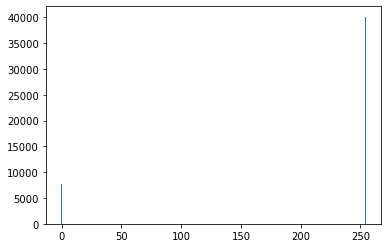

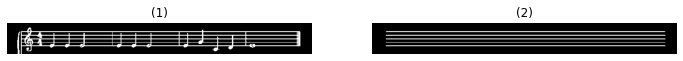

In [99]:
img = binary(io.imread('dataset/test.png'), 230)*255
showHist(img)
img = 255 - img

horizontal = np.copy(img)
cols = horizontal.shape[1]
horizontal_size = cols//15
horizontal_se = np.ones((1, horizontal_size)).astype(np.bool)
# horizontal_se = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])
horizontal = erode(horizontal, horizontal_se)
horizontal = dilate(horizontal, horizontal_se)
show_images([img, horizontal])

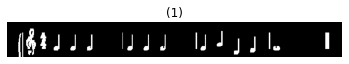

In [81]:
vertical = np.copy(img)
rows = vertical.shape[0]
vertical_size = rows//15
vertical_se = np.ones((vertical_size, 1)).astype(np.bool)
vertical = erode(vertical, vertical_se)
vertical = dilate(vertical, vertical_se)
# vertical = 255 - vertical
show_images([vertical])

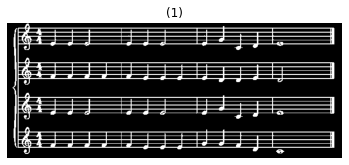

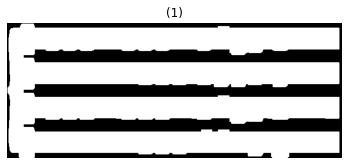

In [144]:
def horizontal_projection(img):
    projected = []
    rows, cols = img.shape
    for i in range(rows):
        proj_sum = 0
        for j in range(cols):
            proj_sum += img[i][j] == 255
        projected.append([255]*proj_sum + [0]*(cols-proj_sum))
    return projected
def crop(img):
    max_ones = 0
    for row in img:
        row_sum = np.sum(row) / 255
        max_ones = np.max(max_ones, row_sum)
    step = max_ones//3
    start = max_ones - step
    cropped = img[:]
    print(cropped)
    for i in range(len(cropped)):
        cropped = cropped[i][start:start+step]
    cropped = np.array(cropped, dtype=np.uint8)
    return cropped
def find_white_rows(img):
    white_rows = []
    rows, cols = img.shape
    for row in range(rows):
        for col in range(cols):
            if img[row][col] == 255 and row not in white_rows:
                white_rows.append(row)
    return sorted(white_rows)

img = io.imread('dataset/note2.png')
if len(img.shape) == 3:
    img = rgb2gray(img)*255
else:
    img = rgb2gray(img)
bin_img = img
original = 255*(img > 230)
img = 255 - original
bin_img = img
show_images([img])
se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
for i in range(10):
    img = dilate(img, se)
show_images([img])


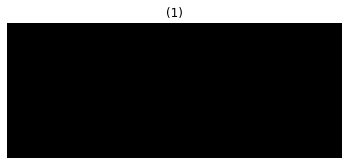

In [145]:
from skimage.measure import find_contours
from skimage.draw import rectangle
contours = find_contours(img, 0.8)
contours_count = 0
line_count = 0
for contour in contours:
    contours_count += 1
    [Xmin, Xmax, Ymin, Ymax] = [int(np.min(contour[:, 1])), int(np.max(contour[:, 1])), int(np.min(contour[:, 0])), int(np.max(contour[:, 0]))]
    if (Xmax - Xmin) < 40 or (Ymax - Ymin) < 40:
        continue
    horizontal_proj = np.zeros(int(Ymax)+1)
    for i in range(int(Ymin), int(Ymax)):
        for j in range(int(Xmin), int(Xmax)):
            if original[i][j] == 0:
                horizontal_proj[i] = horizontal_proj[i] + 1
    i = Ymin
    count = 0
    lines = []
    while i < Ymax:
        while i < Ymax and horizontal_proj[i] <= 10:
            i = i + 1
        start = i
        while i < Ymax and horizontal_proj[i] > 10:
            i = i + 1
        end = i
        if end - start >= 15:
            count = count + 1
            if count%2 == 1:
                lines.append(((Xmin, start), (Xmax, end)))
                if contours_count == 0:
                    line_count = line_count + 1
                rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax, Xmax), shape=original.shape)
                rr = np.array(rr,dtype='int')
                cc = np.array(cc,dtype='int')
                img[rr, cc] = 0
show_images([img])

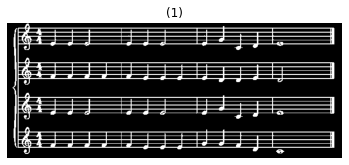

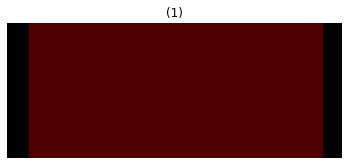

In [146]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb

show_images([bin_img])
staves = bin_img
sz = 45
horz_se = np.ones((1, sz)).astype(np.bool)
vert_se = np.ones((sz, 1)).astype(np.bool)
mat_se = np.ones((sz, sz)).astype(np.bool)
# print(vert_se, horz_se)
staves = dilate(staves, vert_se)
staves = erode(staves, horz_se)

staff_regions = label(staves)
label_overlay = label2rgb(staff_regions, image=bin_img, bg_label=0)
show_images([label_overlay])

In [8]:
def horiz_proj(img):
    rows, cols = img.shape
    count = 0
    hist = []
    for i in range(rows):
        for j in range(cols):
            count = count + (img[i][j] != 1)
        hist.append(count)
        count = 0
    return hist

In [9]:
def vert_proj(img):
    rows, cols = img.shape
    count = 0
    hist = []
    for i in range(cols):
        for j in range(rows):
           count = count + (img[i][j] != 1)
        hist.append(count)
        count = 0

In [35]:
def remove_staff(img, idx):
    rows, cols = img.shape
    for i in range(cols):
        if img[idx][i] == 0:
            total = 0
            for j in range(-3, 4):
                if idx+j > 0 and idx + j < rows:
                    total += img[idx+j][i]
            if total > 1000:
                for j in range(-2, 3):
                    if idx+j > 0 and idx + j < rows:
                        img[idx+j][i] = 255
    return img

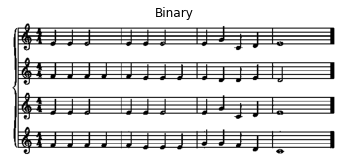

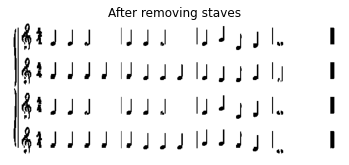

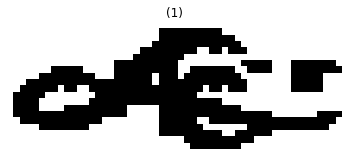

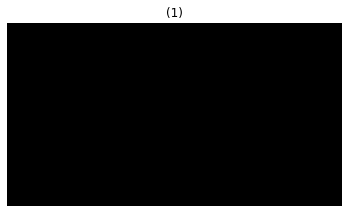

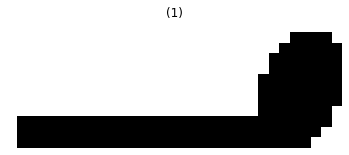

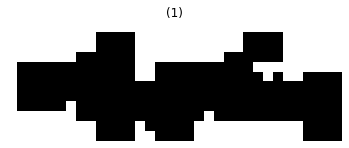

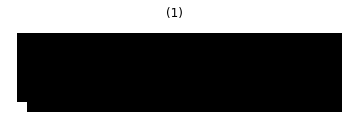

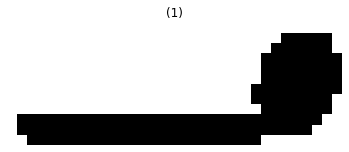

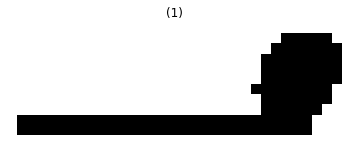

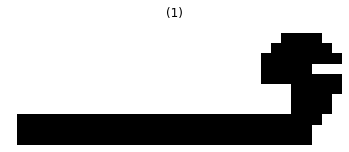

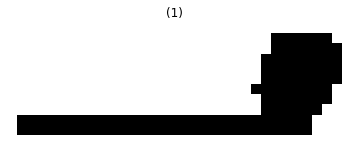

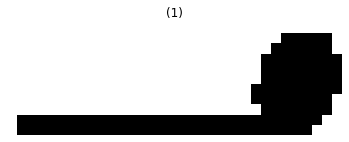

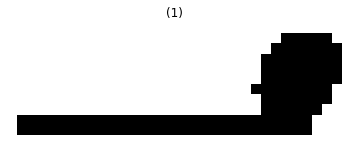

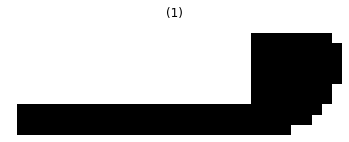

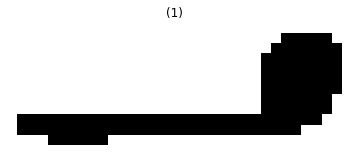

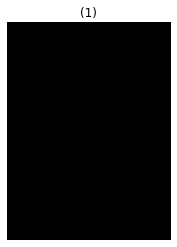

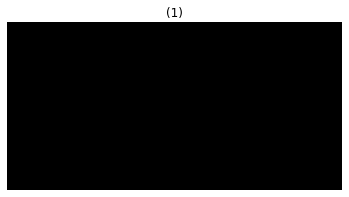

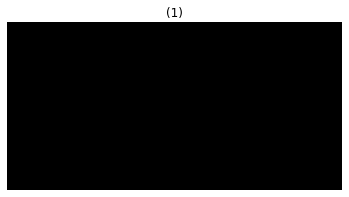

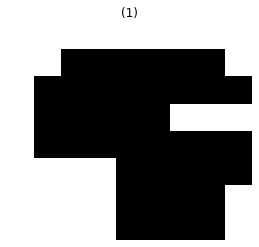

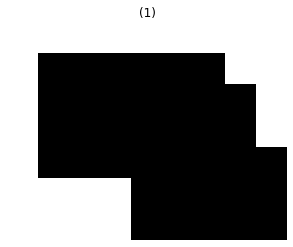

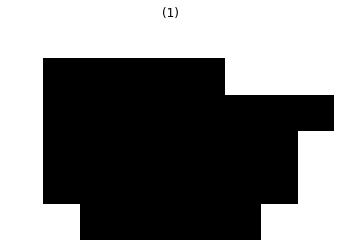

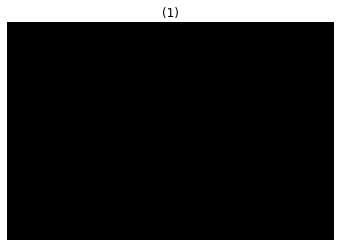

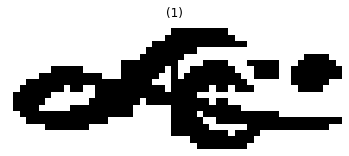

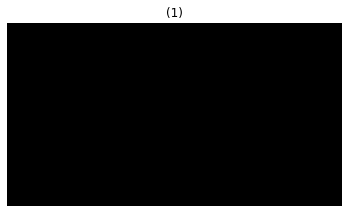

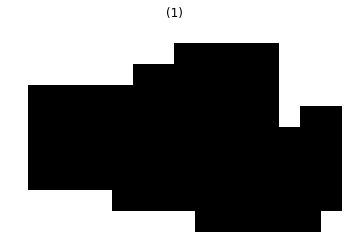

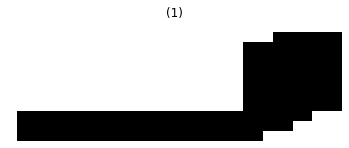

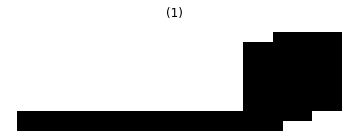

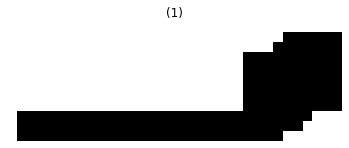

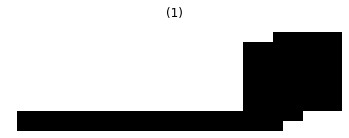

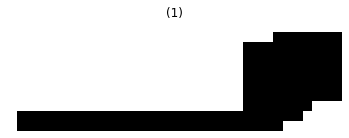

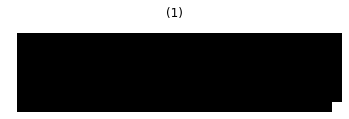

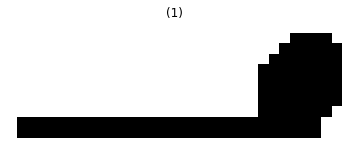

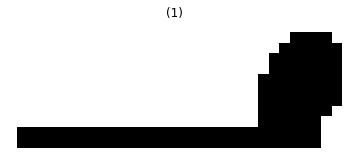

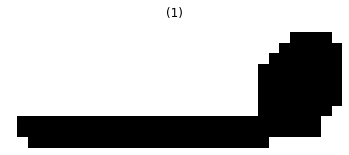

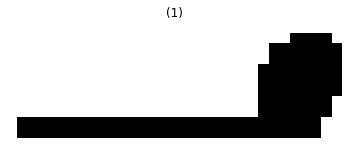

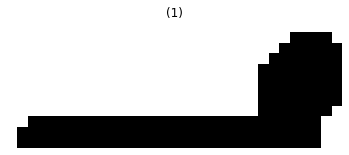

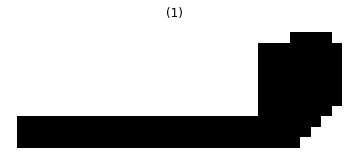

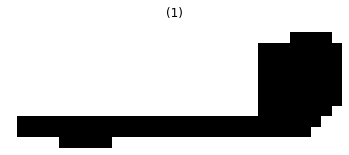

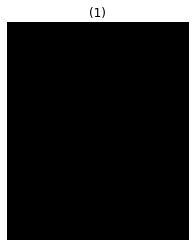

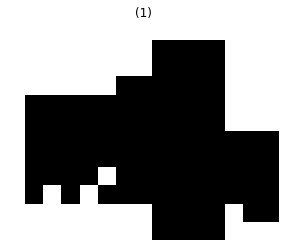

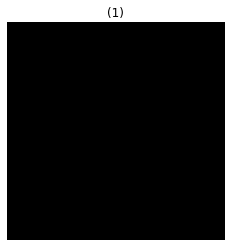

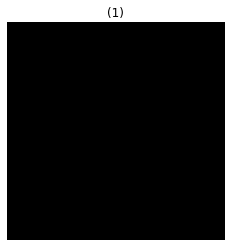

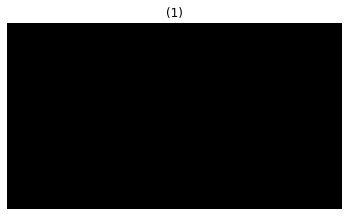

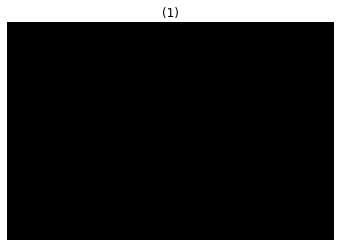

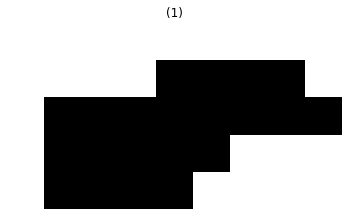

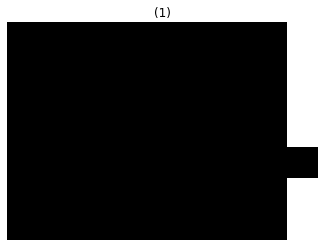

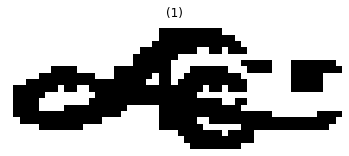

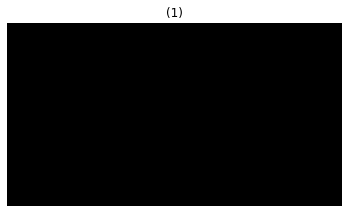

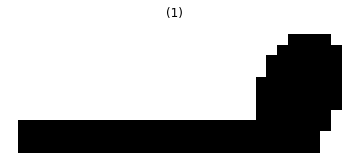

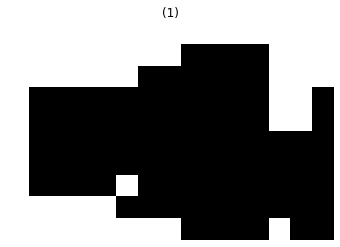

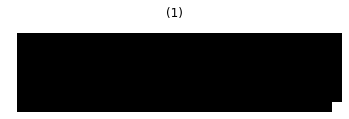

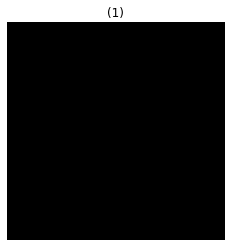

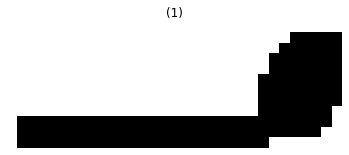

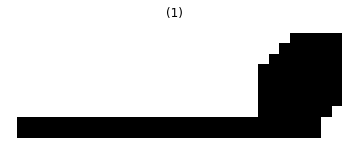

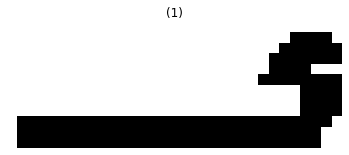

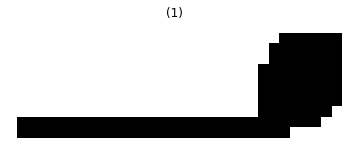

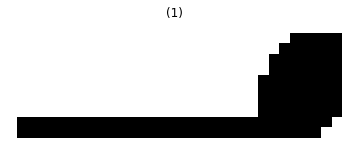

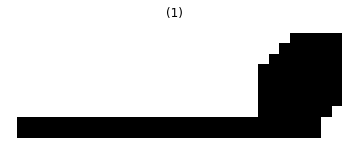

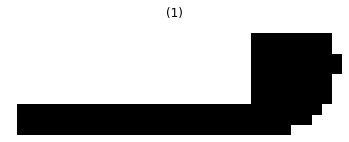

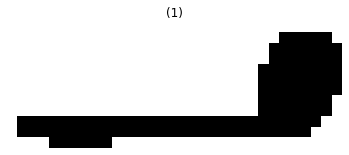

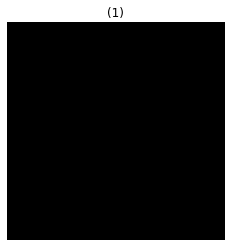

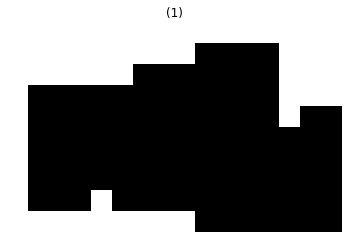

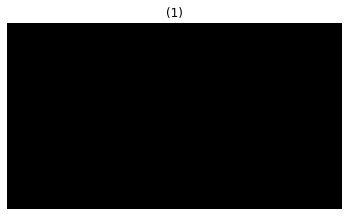

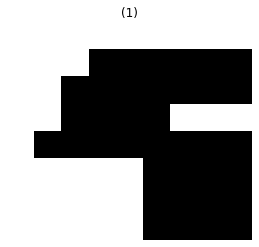

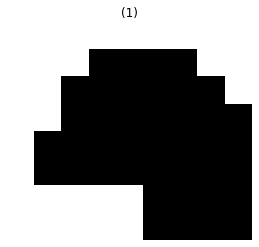

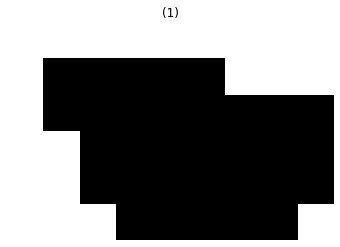

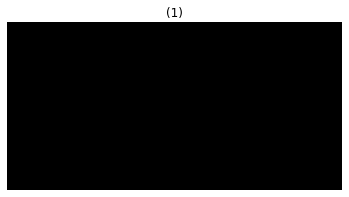

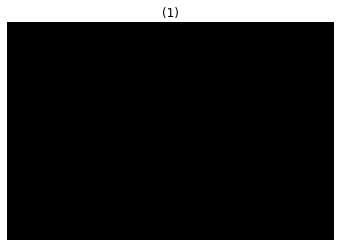

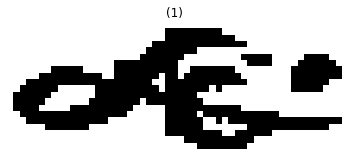

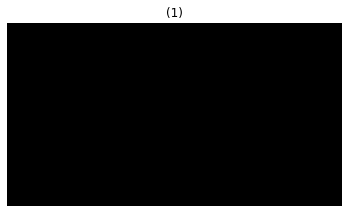

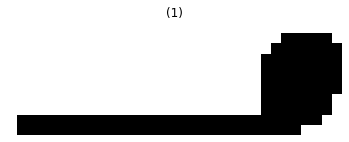

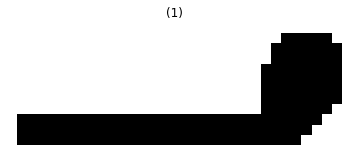

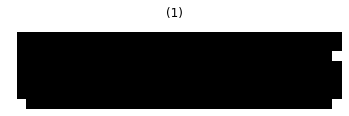

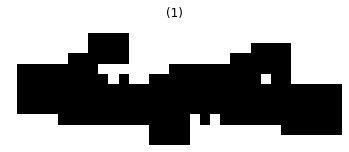

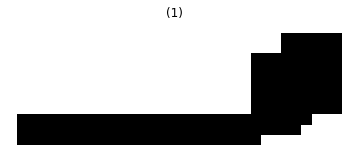

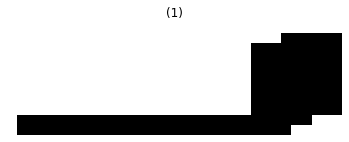

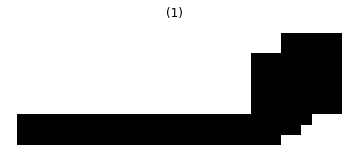

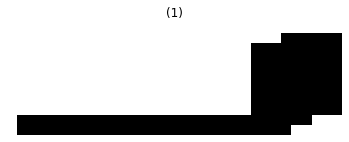

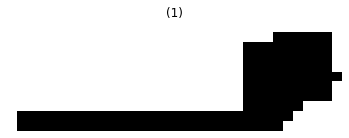

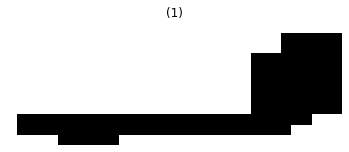

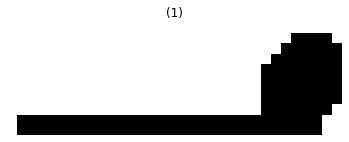

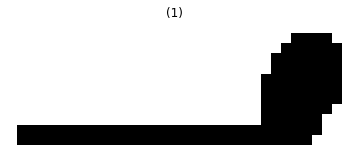

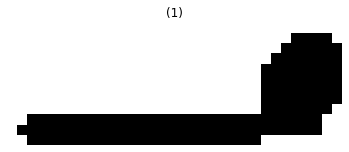

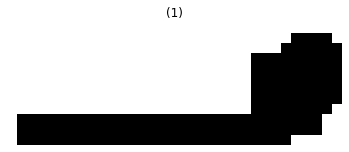

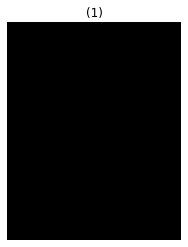

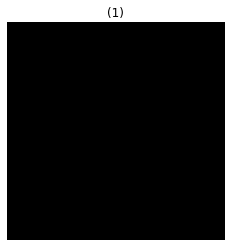

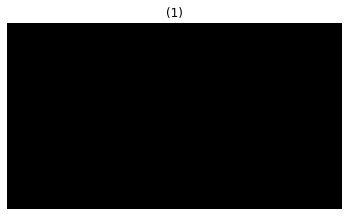

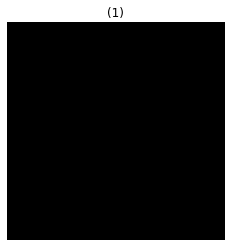

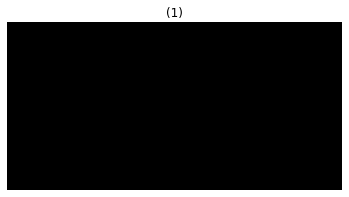

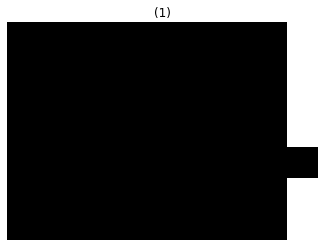

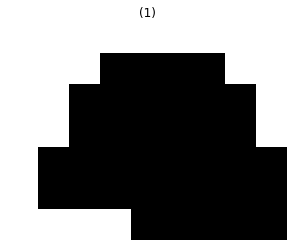

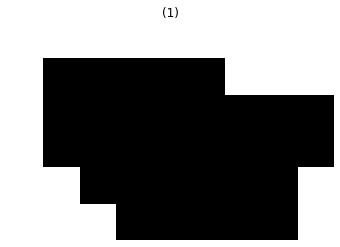

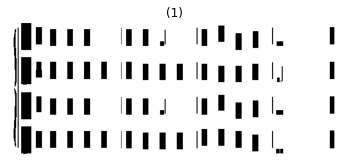

In [67]:
from skimage.measure import find_contours
from skimage.draw import rectangle
from matplotlib.pyplot import imshow

original_img = io.imread('dataset/note2.png')

gray_img = np.copy(original_img)
if len(gray_img.shape) == 3:
    gray_img = rgb2gray(gray_img)*255
else:
    gray_img = rgb2gray(gray_img)

bin_img = 255*(gray_img > 240)
show_images([bin_img], ['Binary'])

horiz_projection = horiz_proj(bin_img)
# vert_projection = vert_proj(bin_img)

staff = []
max_horiz_proj = np.max(horiz_projection)
for i in range(len(horiz_projection)):
    if horiz_projection[i] > max_horiz_proj/8:
        bin_img = remove_staff(bin_img, i)
show_images([bin_img], ['After removing staves'])

t_bin = np.copy(bin_img)
contours = find_contours(t_bin, 0.8)
bounding_boxes = []
for contour in contours:
    box = [np.min(contour[:, 1]), np.max(contour[:, 1]), np.min(contour[:, 0]), np.max(contour[:, 0])]
    bounding_boxes.append(box)

symbols = []
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=t_bin.shape)
    rr = np.array(rr,dtype='int')
    cc = np.array(cc,dtype='int')
    is_note = Xmin > 10 and (Ymax - Ymin) / (Xmax - Xmin) < 15
    if not is_note:
        continue
    symbol = t_bin[rr, cc]
    symbols.append(symbol)
    t_bin[rr, cc] = 0
for symbol in symbols:
    show_images([symbol])
show_images([t_bin])

